# Morphological Operations, Edge Detection and SIFT

## Morphological operations
Morphological operations, such as dilation, erosion, opening, and closing, are used to process binary images by modifying the shapes of objects. These operations help in removing noise, closing gaps in objects, or enhancing object structures, making the image cleaner and better suited for subsequent tasks like edge detection or contour extraction.

## Edge Detection
Edge detection is a technique used to identify the boundaries or outlines of objects within an image. Methods like the Canny Edge Detector highlight sharp changes in intensity, which correspond to edges, making it easier to detect and segment objects from the background. It is widely used in computer vision tasks to simplify image analysis by reducing the amount of data while preserving important structural information.


## SIFT
SIFT is a feature detection algorithm that identifies key points in an image that are invariant to scale and rotation. These features are used for tasks like object recognition, image stitching, and tracking across different scales and orientations.

The following is the set of imports and libraries I used across my whole time foing these project


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
import imutils

import lightgbm as lgb

from skimage import util, exposure
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

from google.colab.patches import cv2_imshow
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
import PIL
import io
from base64 import b64decode, b64encode
import html
import time
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Morphological Operations

## Binary Images
A binary image is a type of image that contains only two pixel values: 0 and 1. The process of converting a grayscale image to a binary image is called thresholding. A common method is to set a pixel value to 1 (white) if it lies between the specified range (i, j) and to 0 (black) otherwise. This simplifies the image, making it easier to apply further transformations like edge detection or morphological operations.

## Morphological Operations
Morphological operations are transformations applied to binary images to either clean up noise or enhance the structure of objects in the foreground. These operations use a small matrix (kernel) to modify the image.

- **Erosion**: This operation shrinks the edges of the foreground object by selecting the minimum pixel value in the kernel. It's used to remove small white noise.
- **Dilation**: This operation expands the edges of the foreground object by selecting the maximum pixel value in the kernel. It’s often used to fill small holes or gaps in the objects.
- **Opening**: A combination of erosion followed by dilation, used to remove noise from the background.
- **Closing**: A combination of dilation followed by erosion, useful for filling small holes in the foreground objects.
- **Gradient**: The difference between dilation and erosion, highlighting the boundaries or edges of objects.
- **Top Hat**: The difference between the original image and its opening. It highlights small bright regions.
- **Black Hat**: The difference between the original image and its closing. It highlights small dark regions.

## Other Transformations
- **Gaussian Blurring**: Used to remove noise from images by averaging pixel values, which helps smooth the image and prepare it for further processing.
- **Laplacian**: This is the second derivative of an image's intensity values. It emphasizes regions of rapid intensity change (i.e., edges).
- **Sobel X/Y**: These are edge detection algorithms that highlight vertical and horizontal lines in the image. Sobel X detects vertical edges, while Sobel Y detects horizontal edges.


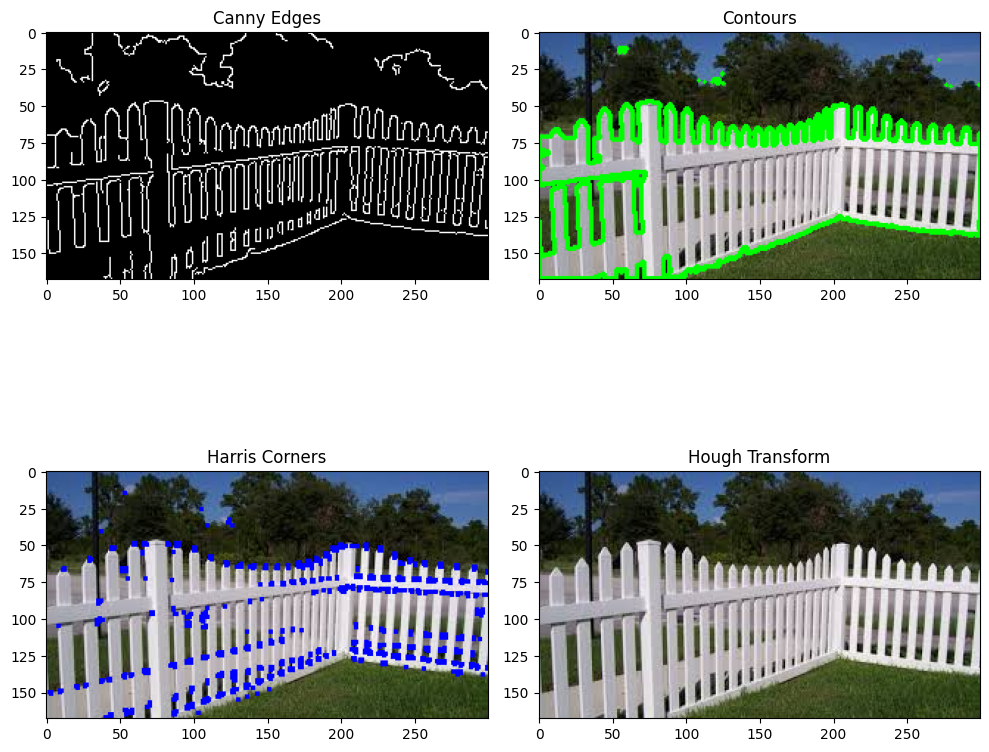

In [4]:
fig = plt.figure(figsize=(10, 10))
rows = 2
columns = 2

main_img = cv2.imread("/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/fence.jpg")

main_rgb = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gray_main = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_main, (5, 5), 0)

# Canny Edge Detection
canny = cv2.Canny(blur, 100, 200)
ax1 = fig.add_subplot(rows, columns, 1)
ax1.imshow(canny, cmap="gray")
ax1.set_title('Canny Edges')

# Contour Detection
ret, img_thresh = cv2.threshold(gray_main, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = main_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
ax2 = fig.add_subplot(rows, columns, 2)
ax2.imshow(contour_img)
ax2.set_title('Contours')

# Harris Corner Detection
gray_float = np.float32(gray_main)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst = cv2.dilate(dst, None)  # Dilate corner points for visibility
harris_img = main_rgb.copy()
harris_img[dst > 0.01 * dst.max()] = [0, 0, 255]
ax3 = fig.add_subplot(rows, columns, 3)
ax3.imshow(harris_img)
ax3.set_title('Harris Corners')

#Hough Line Transform
edges = cv2.Canny(gray_main, 50, 150)
hough_lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
hough_img = main_rgb.copy()

# Draw lines
if hough_lines is not None:
    for rho, theta in hough_lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(hough_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

ax4 = fig.add_subplot(rows, columns, 4)
ax4.imshow(hough_img)
ax4.set_title('Hough Transform')

plt.tight_layout()
plt.show()


# Edge, Corner and Shape Detection

## 1. Canny Edge Detection
Canny edge detection is a 4 step  algorithm used to detect a wide range of edges in an image. It was created by Canny in 1986.

It first computes gradients using Sobel filters and then thins out edges to a single pixel width through non-maximum suppression. Basically as we saw above the Sobel filters is a set of generaal filter to detect gradients and what NMS does is that if an edge is surrounded by other edge pixels we only choose that one to get a fine set of edges.

 The algorithm selects the most important edges using **hysteresis thresholding**, where you have two thresholds: upper and lower. Edges above the upper threshold are always accepted, while those below the lower threshold are rejected. Edges between the thresholds are accepted only if they are connected to an edge above the upper threshold.

### Basic Math:
1. **Gradient Calculation**: The gradient (rate of change) of the image intensity is computed using the Sobel operator: mainly the gradients in the x and y directions.
   
2. **Magnitude of the Gradient**: The magnitude of the gradient gives us the strength of the edge at a pixel:
   
3. **Angle of the Gradient**: The angle (direction) of the edge is calculated as dy/dx
   
4. **Hysteresis Thresholding**: This technique selects edges based on two thresholds:
   - Those edges above the higher threshold are selceted
   - Those edges beolow the lower threshold are rejected
   - Low threshold: Edges between the high and the low are selected only if connected to strong edges (edges above high threshold).

## 2. Harris Corner Detection
The next logical question is how do we detect corners. If you think about it corners are just intersetion of 2 edges. Harris Corner Detection identifies points where gradients in two different directions are significant. Corners are areas where the image intensity changes significantly in both x and y directions. This is helpful in tasks like image stitching or tracking.


## 3. Hough Transformation
The Hough Transform is used to detect shapes, particularly lines and circles, in an image. It transforms points in the image space into curves in the Hough parameter space. For lines, it uses the parametric form of a line in polar coordinates: P = x cosθ + y sin  θ. Where P (rho) is the perpendicular distance from the origin to the line, and  θ is the angle of the perpendicular. We create a grid of all values of  P and  θ for each line to get the most likely outcome


## 4. Watershed Algorithm
The Watershed algorithm is a region-based segmentation method. It treats the image as a topographic surface where high-intensity values represent ridges, and low-intensity values represent valleys. It "floods" the surface starting from predefined markers (objects), and the watershed lines separate the objects.


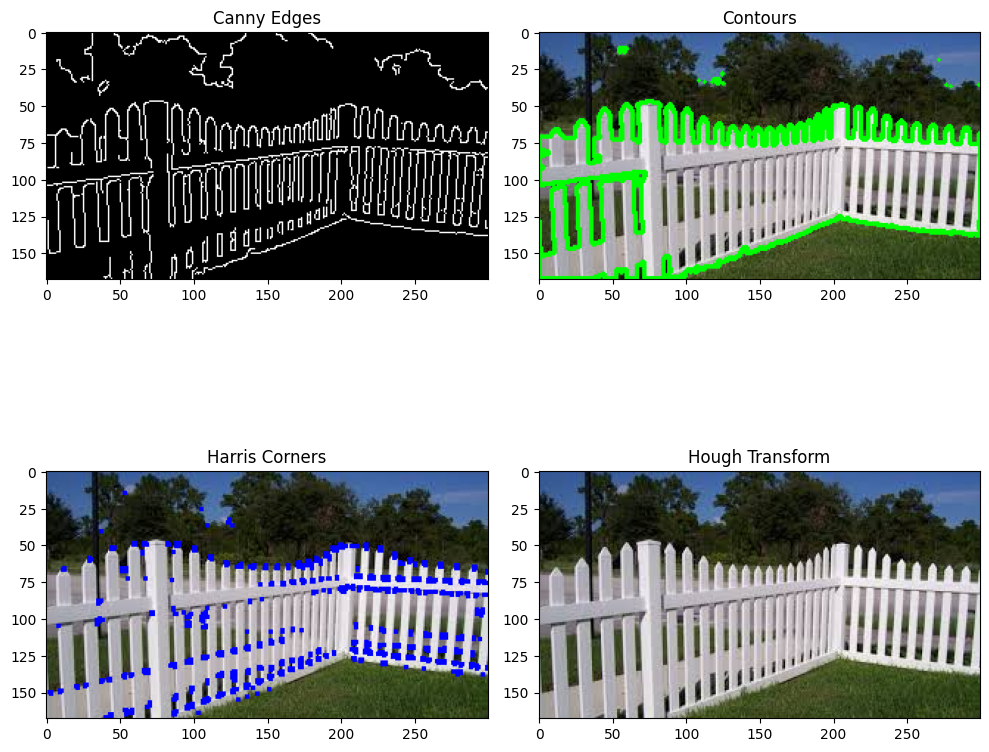

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))

rows = 2
columns = 2

main_img = cv2.imread("/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/fence.jpg")

main_rgb = cv2.cvtColor(main_img, cv2.COLOR_BGR2RGB)
gray_main = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray_main, (5, 5), 0)

# --- Canny Edge Detection ---
canny = cv2.Canny(blur, 100, 200)
ax1 = fig.add_subplot(rows, columns, 1)
ax1.imshow(canny, cmap="gray")
ax1.set_title('Canny Edges')

# --- Contour Detection ---
ret, img_thresh = cv2.threshold(gray_main, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_img = main_rgb.copy()
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)
ax2 = fig.add_subplot(rows, columns, 2)
ax2.imshow(contour_img)
ax2.set_title('Contours')

# Harris Corner Detection
gray_float = np.float32(gray_main)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
harris_img = main_rgb.copy()
harris_img[dst > 0.01 * dst.max()] = [0, 0, 255]
ax3 = fig.add_subplot(rows, columns, 3)
ax3.imshow(harris_img)
ax3.set_title('Harris Corners')

# Hough Line Transform
edges = cv2.Canny(gray_main, 50, 150)
hough_lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=150)
hough_img = main_rgb.copy()

# Draw lines
if hough_lines is not None:
    for rho, theta in hough_lines[:, 0]:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(hough_img, (x1, y1), (x2, y2), (0, 255, 0), 2)

ax4 = fig.add_subplot(rows, columns, 4)
ax4.imshow(hough_img)
ax4.set_title('Hough Transform')

plt.tight_layout()
plt.show()


# Use cases

### 1. Coin Counting
In this case, we apply edge detection using the Canny method and detect the contours to count the number of coins in the image. Canny is used to find edges, while contour detection is used to sepreate foreground and background.
A subtle con about this method it if we have coing sitting egde to edge or overlapping it might be counted as one big coin

We try to fix this using morphological operations like opening and then followed by the distance transform to separate overlapping objects. This is ideal for situations where objects are clumped together.


### 2. Shape Detection
Here, we use contour approximation to detect different shapes (triangles, rectangles, circles) based on their geometrical properties like the number of edges. Contour approximation simplifies the object and makes it easy to classify the shape.


## 3. Object Detection for Horses
One way to detect objets is that we try to detect objects based on edges. In this case we do this for horse by selecting the largest contour/edge. This obviously cannot be used in generaal use cases as many objects may have the same structure/ skeleton


coins in the image :  5


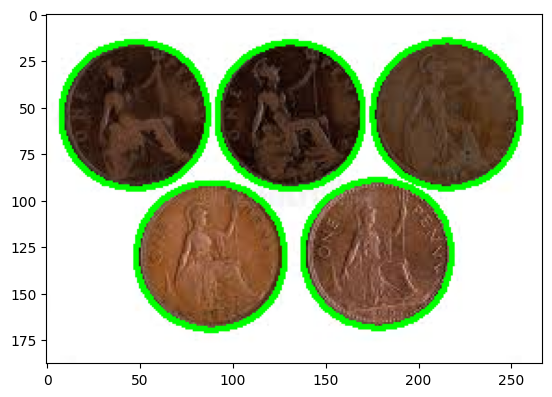

In [9]:
# Coin detection

image = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/coins.jpg')
# image2 = cv2.imread('/content/1.jpg')
# Try uncommenting this line and trying the algorithm

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

ret,threshold = cv2.threshold(image,127,255,cv2.THRESH_BINARY)

blur = cv2.GaussianBlur(gray, (11, 11), 0)
canny = cv2.Canny(blur, 30, 150, 3)
dilated = cv2.dilate(canny, (1, 1), iterations=1)

plt.imshow(dilated, cmap="gray")

(cnt, hierarchy) = cv2.findContours(
    dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)


rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cv2.drawContours(rgb, cnt, -1, (0, 255, 0), 2)

print("coins in the image : ", len(cnt))
plt.imshow(rgb)


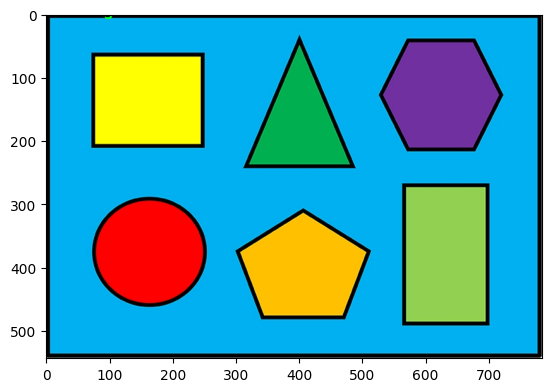

In [39]:
shape2_image = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/Shapes.jpg')
shape2_gray = cv2.cvtColor(shape2_image, cv2.COLOR_BGR2GRAY)
shape2_thresh = cv2.adaptiveThreshold(shape2_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,51,7)

shape2_cnts = cv2.findContours(shape2_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
shape2_cnt = imutils.grab_contours(shape2_cnts)
for c in shape2_cnt:
    shape = ""
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.04 * peri, True)

    if len(approx) == 3:
        shape = "triangle"

    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)

        shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

    # Pentagon
    elif len(approx) == 5:
        shape = "pentagon"

    # Otherwise assume as circle or oval
    else:
        (x, y, w, h) = cv2.boundingRect(approx)
        ar = w / float(h)
        shape = "circle" if ar >= 0.95 and ar <= 1.05 else "oval"
    x,y,w,h = cv2.boundingRect(c)
    cv2.putText(shape2_image, shape, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)  # Offset the text

plt.imshow(cv2.cvtColor(shape2_image, cv2.COLOR_BGR2RGB))
plt.show()

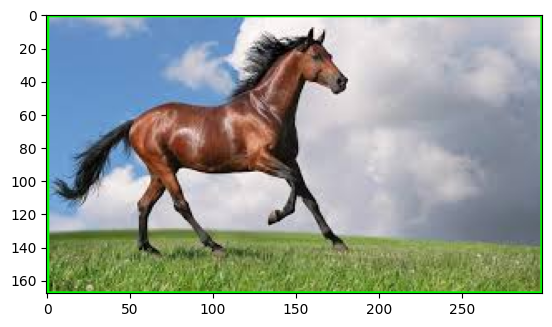

In [40]:

horse_img = cv2.imread("/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/horse2.jpg")
horse_gray = cv2.cvtColor(horse_img, cv2.COLOR_BGR2GRAY)

horse_blurred = cv2.GaussianBlur(horse_gray, (5,5), 0)
horse_thresh = cv2.threshold(horse_blurred,127,1, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

horse_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
horse_dilated = cv2.dilate(horse_thresh,horse_kernel, iterations = 1)

horse_cnt = cv2.findContours(horse_dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE )
horse_cnt = imutils.grab_contours(horse_cnt)

for c in horse_cnt:
  x,y,w,h = cv2.boundingRect(c)
  cv2.rectangle(horse_img, (x,y), (x+w,y+h), (0,255,0), 2)

horse_rgb = cv2.cvtColor(horse_img, cv2.COLOR_BGR2RGB)
plt.imshow(horse_rgb)


# SIFT

## SIFT: Scale-Invariant Feature Transform

SIFT is a powerful texture and feature detector that identifies and matches interesting key points (features) in images. Unlike edge detection, which focuses on color variations along edges, SIFT detects unique and interesting 'blobs' through the derivatives of the image. It is **scale and rotation invariant**, meaning these blobs can be detected even if the image is rotated, scaled up or down, or lit differently.

### Choosing Blobs (Keypoints):
1. **Rich Image Content**: We detect areas with high color or brightness variation.
2. **Well-Defined Representation**: We can calculate a unique signature from the derivative values around the keypoint.
3. **Stable Location**: The position of the blob should remain stable relative to the rest of the image.
4. **Rotation and Scale Invariant**: The blob should be detectable no matter how the image is rotated, resized, or illuminated.

### Steps of SIFT:
1. **Scale Space Extrema Detection (DOG)**: SIFT detects interesting points by applying the Difference of Gaussian (DOG) across scales. This is roughly equivalent to using the Laplacian with smaller sigma values, and the resulting extrema become the interest points.
2. **Keypoint Localization**: After detecting the extrema, we find the exact position and scale of each keypoint and select them based on their stability.
3. **Orientation Assignment**: The local image gradients around each keypoint are analyzed to determine its orientation, helping to create rotation-invariant features.
4. **Keypoint Description**: A descriptor is built from the local image gradients around the keypoint, capturing the scale, orientation, and other characteristics.

### Alternatives to SIFT:
Some alternatives include **SURF** (Speeded-Up Robust Features) and **ORB** (Oriented FAST and Rotated BRIEF), which offer faster computations in certain cases but may not capture features as robustly as SIFT.


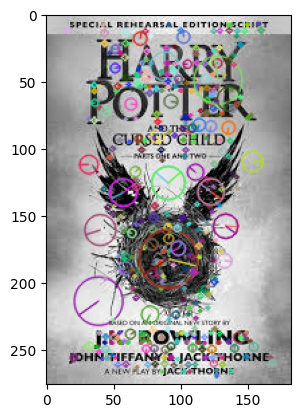

In [41]:
img_main = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/harry1.jpg', cv2.IMREAD_GRAYSCALE)

sift1 = cv2.SIFT_create()
keypoints1 = sift1.detect(img_main, None)

img_main = cv2.drawKeypoints(img_main,keypoints1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_main)
plt.show()


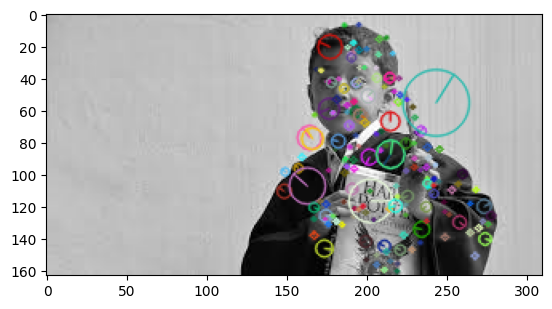

In [42]:
img_main_2 = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/harry2.jpg', cv2.IMREAD_GRAYSCALE)

sift2 = cv2.SIFT_create()
keypoints2 = sift2.detect(img_main_2, None)

img_main_2 = cv2.drawKeypoints(img_main_2,keypoints2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_main_2)
plt.show()


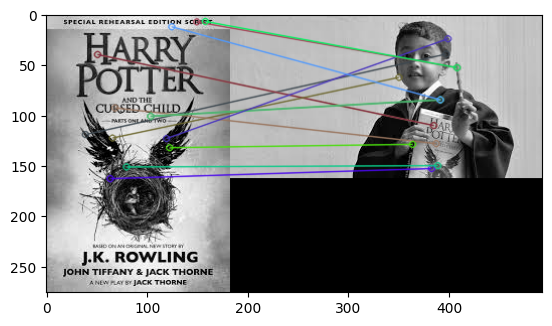

(<matplotlib.image.AxesImage at 0x7ee9e07e1fc0>, None)

In [43]:
img_main = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/harry1.jpg', cv2.IMREAD_GRAYSCALE)
img_main_2 = cv2.imread('/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/harry2.jpg', cv2.IMREAD_GRAYSCALE)

sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(img_main, None)
kp2, des2 = sift.detectAndCompute(img_main_2, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

good = []
for m,n in matches:
 if m.distance < 0.75*n.distance:
  good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img_main,kp1,img_main_2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3),plt.show()



Using SIFT we can do image stitching as follows

Detecting keypoints similar SIFT like finding DOG, Harris etc for all images
Find matching keypoint description beteween images
Using Ransac (similar to SVM) where you use 2 random points and the connect them and then check how many points within a small cylcindrical area of the line.
Applying transformation using homographic matrix


Stiching Images: ... 


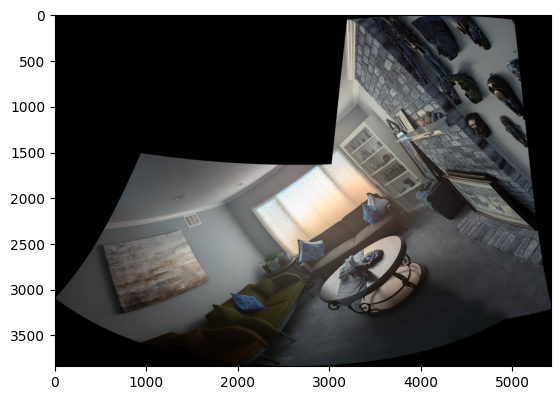

In [44]:
images = []
image_paths = ["/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/Stitch1.jpg", "/content/drive/MyDrive/Computer_Vision/SIFT_and_Edge/Stitch2.jpg"]

for image_path in image_paths:
  image = cv2.imread(image_path)
  images.append(image)

print("Stiching Images: ... ")
stitcher = cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

if status == 0:
  plt.imshow(stitched)
  plt.show()
